In [ ]:
!pip install -q accelerate peft bitsandbytes transformers
!pip install langchain faiss-cpu sentence-transformers

In [ ]:
!pip install -U langchain-community

###Pipeline
Collect Data -> Preprocessing -> Rag for context + Finetune -> Generated Answer → UI (Streamlit/Gradio)
Hallucination testing...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/Data\ ChatBot

faiss_tthc		postprocessed_tthc.csv	Vistral-finetuned-final
phogpt-finetuned-final	test_phogpt.jsonl
postprocessed_link.csv	train_phogpt.jsonl


In [ ]:
import pandas as pd

data_link = pd.read_csv('/content/drive/MyDrive/Data ChatBot/postprocessed_link.csv')
data_tthc = pd.read_csv('/content/drive/MyDrive/Data ChatBot/postprocessed_tthc.csv')

In [ ]:
data_link.drop('phanLoai', axis=1, inplace=True)


In [ ]:
data_link.head(1)

,link,boNganh,cauHoi,cauTraLoi,TTHCLienQuan,cauHoiLienQuan
0,https://dichvucong.gov.vn/p/home/dvc-chi-tiet-...,Thanh tra Chính phủ,Pháp luật có quy định về thời hạn thông báo qu...,Nhằm tránh tình trạng không trả lời hoặc trả l...,['https://dichvucong.gov.vn/p/home/dvc-chi-tie...,['https://dichvucong.gov.vn/p/home/dvc-chi-tie...


In [ ]:
data_tthc.head(1)

,link,maThuTuc,soQuyetDinh,tenThuTuc,capThucHien,loaiThuTuc,linhVuc,trinhTuThucHien,cachThucThucHien,thanhPhanHoSo,...,coQuanThucHien,coQuanCoThamQuyen,diaChiTiepNhanHoSo,coQuanDuocUyQuyen,coQuanPhoiHop,ketQuaThucHien,canCuPhapLy,yeuCauDieuKienThucHien,tuKhoa,moTa
0,https://dichvucong.gov.vn/p/home/dvc-chi-tiet-...,1.003755,839/QĐ-BNNMT,"Cấp, cấp lại thẻ, dấu kỹ thuật đăng kiểm viên ...",Cấp Bộ,TTHC được luật giao quy định chi tiết,Thủy sản,18.1. Trình tự thực hiện:\r\na) Cá nhân nộp 01...,"Hình thức nộp Thời hạn giải quyết Phí, lệ phí ...","Bao gồm\r\nTên giấy tờ Mẫu đơn, tờ khai Số lượ...",...,Cục Thủy sản và Kiểm ngư - Bộ Nông nghiệp và M...,Không có thông tin,Không có thông tin,Không có thông tin,Không có thông tin,"Thẻ, dấu kỹ thuật đăng kiểm viên tàu cá",Số ký hiệu Trích yếu Ngày ban hành Cơ quan ban...,.,Không có thông tin,Không có thông tin


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
import numpy as np


In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

False


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
text_cols = data_tthc.keys()
text_cols

Index(['link', 'maThuTuc', 'soQuyetDinh', 'tenThuTuc', 'capThucHien',
       'loaiThuTuc', 'linhVuc', 'trinhTuThucHien', 'cachThucThucHien',
       'thanhPhanHoSo', 'doiTuongThucHien', 'coQuanThucHien',
       'coQuanCoThamQuyen', 'diaChiTiepNhanHoSo', 'coQuanDuocUyQuyen',
       'coQuanPhoiHop', 'ketQuaThucHien', 'canCuPhapLy',
       'yeuCauDieuKienThucHien', 'tuKhoa', 'moTa'],
      dtype='object')

In [ ]:
col_to_drop = ['link','maThuTuc','soQuyetDinh','capThucHien','loaiThuTuc','linhVuc','tuKhoa']

In [ ]:
data_chunk = data_tthc.drop(col_to_drop, axis=1)

In [ ]:
def count_total_tokens(row):
    total_text = " ".join([str(row[col]) for col in text_cols if col in row])
    return len(tokenizer.encode(total_text, add_special_tokens=True, truncation=False))
data_chunk['Total token'] = data_chunk.apply(count_total_tokens, axis=1)


NameError: name 'tokenizer' is not defined

In [ ]:
data_link['num_tokens'] = data_link['cauTraLoi'].apply(lambda x: len(tokenizer.encode(str(x))))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

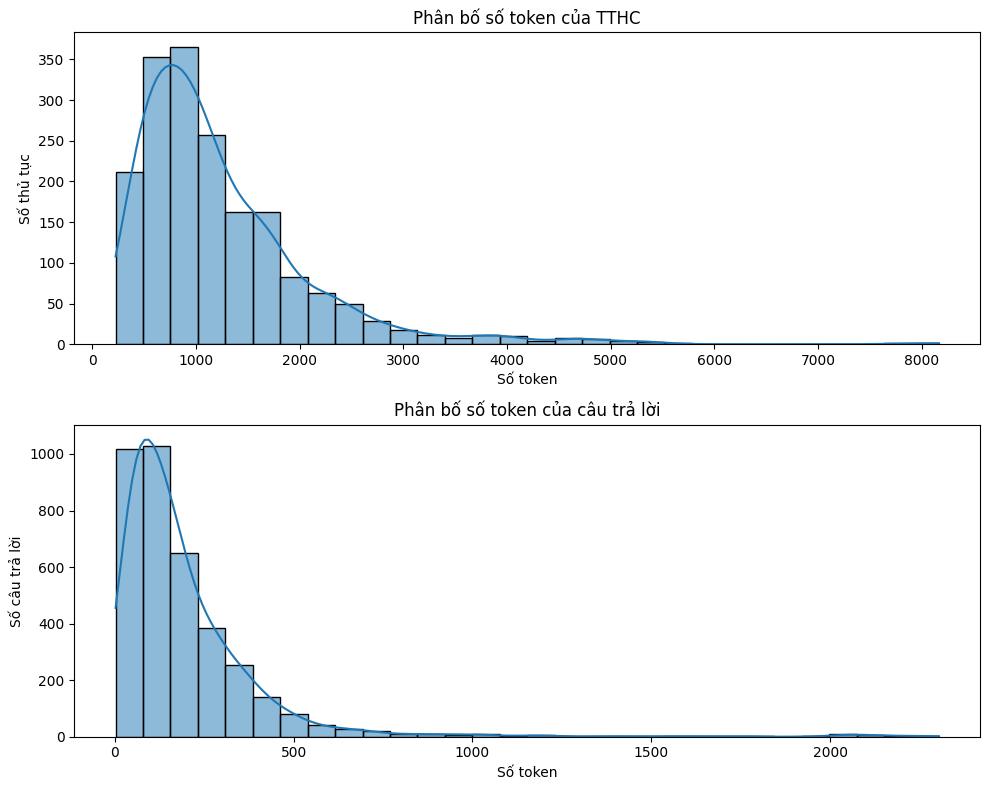

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # 2 hàng, 1 cột

sns.histplot(data_chunk['Total token'], bins=30, kde=True, ax=axes[0])
axes[0].set_xlabel('Số token')
axes[0].set_ylabel('Số thủ tục')
axes[0].set_title('Phân bố số token của TTHC')

sns.histplot(data_link['num_tokens'], bins=30, kde=True, ax=axes[1])
axes[1].set_xlabel('Số token')
axes[1].set_ylabel('Số câu trả lời')
axes[1].set_title('Phân bố số token của câu trả lời')

plt.tight_layout()
plt.show()

Số câu trả lời >1000 token chỉ đâu đó 1%

In [ ]:
count_1000 = (data_link['num_tokens'] > 1000).sum()
count_1000

np.int64(47)

In [ ]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=50
)
chunks_tthc = []
for index, row in data_chunk.iterrows():
  procedure_name = row['tenThuTuc']
  for col in data_chunk.keys():
    content = str(row[col]).strip()
    if len(content) > 800:
        sub_chunks = splitter.split_text(content)
        for i, sub_chunk in enumerate(sub_chunks):
            text = f"Tên thủ tục: {procedure_name}\n{col}: {sub_chunk}"
            chunks_tthc.append({
                "content": text,
                "metadata": {
                    "procedure_name": procedure_name,
                    "column": col,
                    "chunk_index": i
                }
            })
    else:
        text = f"Tên thủ tục: {procedure_name}\n{col}: {content}"
        chunks_tthc.append({
            "content": text,
            "metadata": {
                "procedure_name": procedure_name,
                "column": col,
                "chunk_index": 0
            }
          })


In [ ]:
for c in chunks_tthc[:5]:
    print(c)

{'content': 'Tên thủ tục: Cấp, cấp lại thẻ, dấu kỹ thuật đăng kiểm viên tàu cá\ntenThuTuc: Cấp, cấp lại thẻ, dấu kỹ thuật đăng kiểm viên tàu cá', 'metadata': {'procedure_name': 'Cấp, cấp lại thẻ, dấu kỹ thuật đăng kiểm viên tàu cá', 'column': 'tenThuTuc', 'chunk_index': 0}}
{'content': 'Tên thủ tục: Cấp, cấp lại thẻ, dấu kỹ thuật đăng kiểm viên tàu cá\ntrinhTuThucHien: 18.1. Trình tự thực hiện:\r\na) Cá nhân nộp 01 bộ hồ sơ về Cục Thuỷ sản và Kiểm ngư;\r\nb) Trường hợp nộp hồ sơ trực tiếp: Cục Thuỷ sản và Kiểm ngư kiểm tra thành phần hồ sơ và trả lời ngay khi cá nhân đến nộp hồ sơ;\r\nc) Trường hợp nộp hồ sơ qua dịch vụ bưu chính hoặc qua môi trường mạng: Trong thời hạn không quá 02 ngày làm việc, Cục Thuỷ sản và Kiểm ngư xem xét tính đầy đủ, nếu hồ sơ chưa đầy đủ theo quy định, Cục Thuỷ sản và Kiểm ngư có văn bản thông báo rõ cho cá nhân bổ sung;', 'metadata': {'procedure_name': 'Cấp, cấp lại thẻ, dấu kỹ thuật đăng kiểm viên tàu cá', 'column': 'trinhTuThucHien', 'chunk_index': 0}}
{'c

In [ ]:
embedding_model = HuggingFaceEmbeddings(model_name="keepitreal/vietnamese-sbert")


/tmp/ipython-input-4227352635.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="keepitreal/vietnamese-sbert")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datase

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
texts = [c["content"] for c in chunks_tthc]
metadatas = [c["metadata"] for c in chunks_tthc]
db = FAISS.from_texts(texts, embedding_model, metadatas=metadatas)

# Lưu lại để dùng sau
db.save_local("/content/drive/MyDrive/Data ChatBot/faiss_tthc")

KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm

embeddings = []
for text in tqdm(texts, desc="Creating embeddings"):
    emb = embedding_model.embed_query(text)
    embeddings.append(emb)
text_embeddings = [(texts[i], embeddings[i]) for i in range(len(texts))]
db = FAISS.from_embeddings(text_embeddings=text_embeddings, embedding=embedding_model)

Creating embeddings: 100%|██████████| 33313/33313 [4:15:56<00:00,  2.17it/s]


In [ ]:
db.save_local("/content/drive/MyDrive/Data ChatBot/faiss_tthc") #sua lai theo duong dan colab